## Local Distances

In [1]:
import sys
sys.path.append('../../')
from fcc_utils import *
%matplotlib inline

In [97]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
# read in Macosko retina data
retina = sc.read_text('../../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t')
# read in Herring colon data
colon = sc.read_text('../../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', delimiter='\t', first_column_names=True)

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [4]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [5]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 

In [6]:
# get useful metrics of counts data
colon.var['mito'] = colon.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon.layers['raw_counts'] = colon.X.copy() # save raw counts in layer
sc.pp.normalize_total(colon, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

Add `Phenograph` clustering information to each `anndata` object

In [18]:
retina_clu = pd.read_csv('pymethods_out/retina_clu.csv', header=None)
retina.obs['cluster'] = retina_clu[0].values

In [20]:
colon_clu = pd.read_csv('pymethods_out/colon_clu.csv', header=None)
colon.obs['cluster'] = colon_clu[0].values

In [21]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}}

In [22]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

---

In [23]:
retina.obs.cluster.value_counts()

0.0    309
1.0    281
2.0    258
3.0    130
4.0     94
5.0     89
6.0     77
7.0     49
8.0     39
Name: cluster, dtype: int64

In [24]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=2)

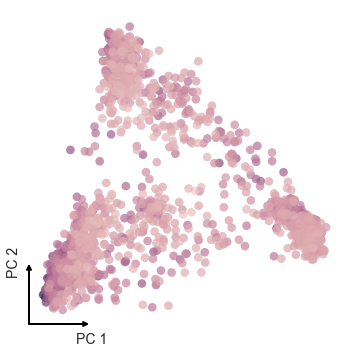

In [25]:
plot_DR(retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'], dim_name='PC')

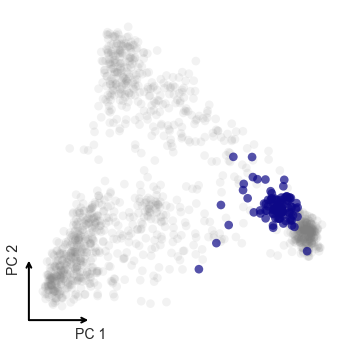

In [57]:
plot_IDs(retina, 'X_pca', 'cluster', IDs=[4], dim_name='PC')

In [58]:
retina.obsm['PCA2'] = retina.obsm['X_pca'].copy()
# save distance matrices in AnnData object for easy access
retina.uns['X_distance'] = distance_matrix(retina.X, retina.X)
retina.uns['PCA2_distance'] = distance_matrix(retina.obsm['PCA2'], retina.obsm['PCA2'])

# calculate simple binary knn graphs for each distance matrix above
knn_graph(retina.uns['X_distance'], k, retina, save_rep='X_knn')
knn_graph(retina.uns['PCA2_distance'], k, retina, save_rep='PCA2_knn')

In [106]:
subset_uns_by_ID(retina, uns_keys=['X_distance','PCA2_distance'], obs_col='cluster', IDs=[4])

# recalculate knn graphs on subset of distance matrices
knn_graph(retina.uns['X_distance_4'], k, retina, save_rep='X_knn_4')
knn_graph(retina.uns['PCA2_distance_4'], k, retina, save_rep='PCA2_knn_4')

In [107]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.uns['X_distance_4'], post=retina.uns['PCA2_distance_4'])
knn = knn_preservation(pre=retina.uns['X_knn_4'], post=retina.uns['PCA2_knn_4'])
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, knn

R: 0.4003
EMD: 0.311
Knn Pres.: 60.163
CPU times: user 175 ms, sys: 3.03 ms, total: 178 ms
Wall time: 178 ms


CPU times: user 162 ms, sys: 14.8 ms, total: 177 ms
Wall time: 90.6 ms


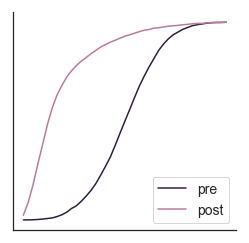

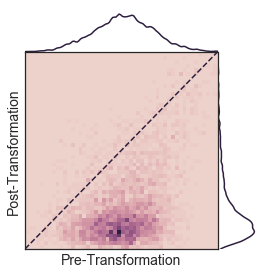

In [108]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
#plt.savefig(fname='../images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

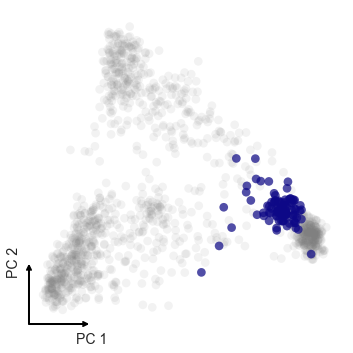

In [11]:
retina_PCA10 = fcc_PCA(matrix=retina.arcsinh_norm(), barcodes=retina.barcodes, n_components=10)
retina_PCA10.plot_barcodes(ranks=['4']) # cones

In [12]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_PCA10.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_PCA10.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (10)'], final_distance_stats['Retina']['EMD']['PCA (10)'], final_distance_stats['Retina']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, knn

R: 0.4781
EMD: 0.1501
Knn Pres.: 65.5274
CPU times: user 273 ms, sys: 16.9 ms, total: 290 ms
Wall time: 293 ms


CPU times: user 10.2 s, sys: 447 ms, total: 10.7 s
Wall time: 10.2 s


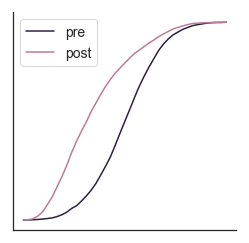

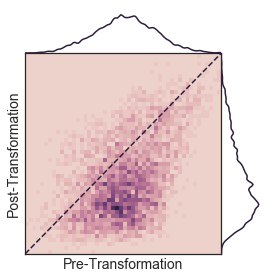

In [13]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_PCA10_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

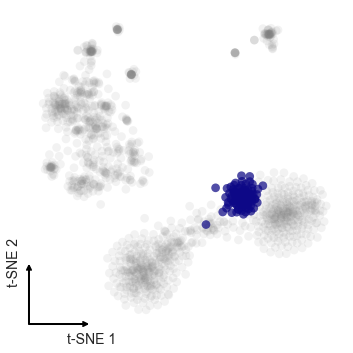

In [14]:
retina_tSNE = DR.from_file('pymethods_out/retina_tSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_tSNE.plot_barcodes(ranks=['4']) # cones

In [15]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_tSNE.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_tSNE.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, knn

R: 0.3688
EMD: 0.2843
Knn Pres.: 66.2743
CPU times: user 271 ms, sys: 17.2 ms, total: 289 ms
Wall time: 292 ms


CPU times: user 10.1 s, sys: 306 ms, total: 10.4 s
Wall time: 9.88 s


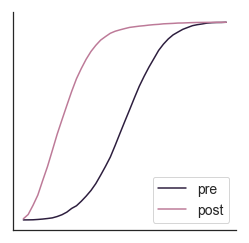

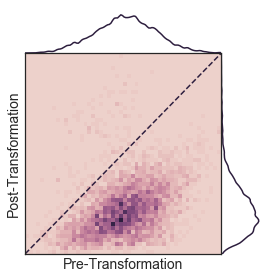

In [16]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

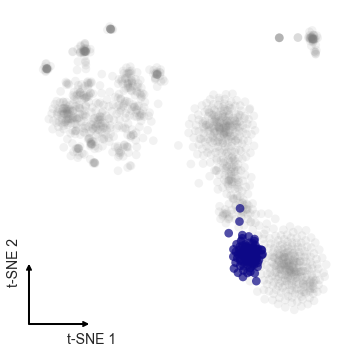

In [17]:
retina_FItSNE = DR.from_file('pymethods_out/retina_FItSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_FItSNE.plot_barcodes(ranks=['4']) # rods & cones

In [18]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_FItSNE.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_FItSNE.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['FIt-SNE'], final_distance_stats['Retina']['EMD']['FIt-SNE'], final_distance_stats['Retina']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, knn

R: 0.3572
EMD: 0.2908
Knn Pres.: 66.5912
CPU times: user 271 ms, sys: 18.4 ms, total: 290 ms
Wall time: 298 ms


CPU times: user 10.1 s, sys: 343 ms, total: 10.4 s
Wall time: 9.94 s


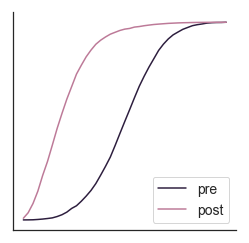

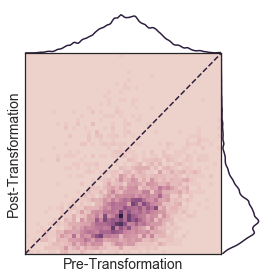

In [19]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

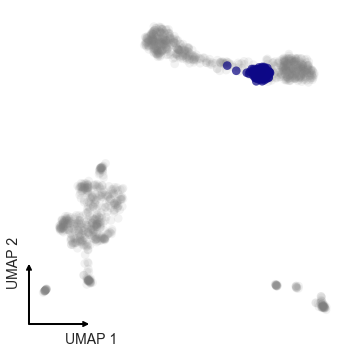

In [20]:
retina_UMAP = DR.from_file('pymethods_out/retina_UMAP.csv', name='UMAP', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_UMAP.plot_barcodes(ranks=['4']) # rods & cones

In [21]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_UMAP.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_UMAP.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, knn

R: -0.0107
EMD: 0.3229
Knn Pres.: 58.6464
CPU times: user 292 ms, sys: 18.6 ms, total: 311 ms
Wall time: 315 ms


CPU times: user 9.85 s, sys: 244 ms, total: 10.1 s
Wall time: 9.59 s


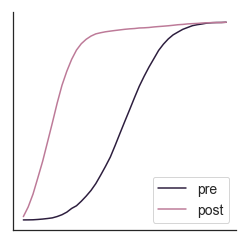

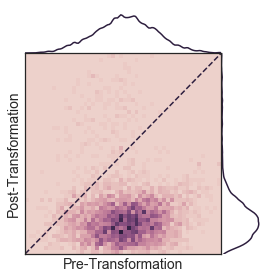

In [22]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

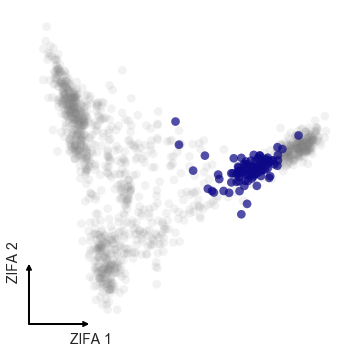

In [23]:
retina_ZIFA = DR.from_file('pymethods_out/retina_ZIFA.csv', name='ZIFA', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_ZIFA.plot_barcodes(ranks=['4']) # rods & cones

In [24]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_ZIFA.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_ZIFA.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, knn

R: 0.4355
EMD: 0.3019
Knn Pres.: 61.1815
CPU times: user 279 ms, sys: 17.6 ms, total: 297 ms
Wall time: 303 ms


CPU times: user 10.2 s, sys: 358 ms, total: 10.6 s
Wall time: 10.4 s


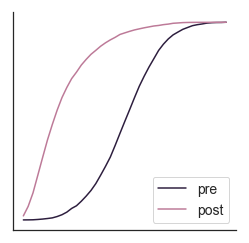

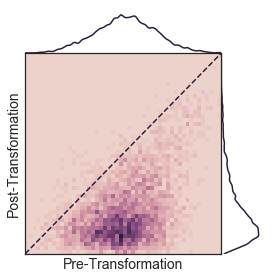

In [25]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

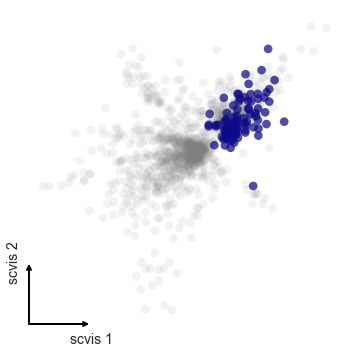

In [31]:
retina_scvis = DR.from_file('scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', name='scvis', labels=[0,0], barcodefile='pymethods_out/retina_clu.csv')
retina_scvis.plot_barcodes(ranks=['4']) # rods & cones

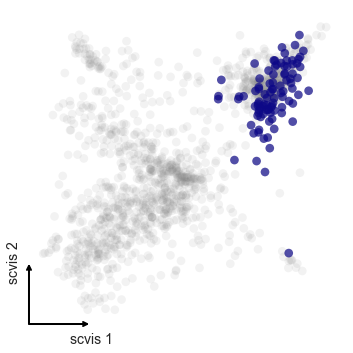

In [32]:
retina_scvis = DR(latent=retina_scvis.arcsinh_norm(norm=None, scale=1), name='scvis', barcodes=retina_scvis.barcodes)
retina_scvis.plot_barcodes(ranks=['4']) 

In [33]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_scvis.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_scvis.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, knn

R: 0.2691
EMD: 0.324
Knn Pres.: 77.4785
CPU times: user 281 ms, sys: 18.7 ms, total: 300 ms
Wall time: 307 ms


CPU times: user 10.2 s, sys: 364 ms, total: 10.6 s
Wall time: 10.3 s


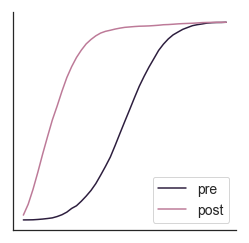

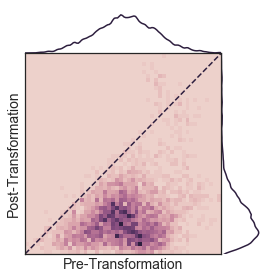

In [34]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

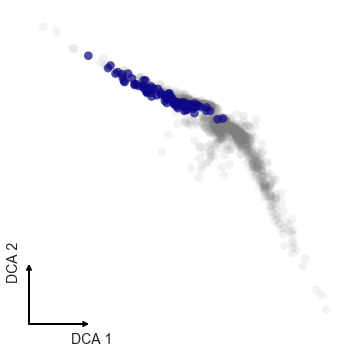

In [35]:
retina_DCA = DR.from_file('pymethods_out/retina_DCA.csv', name='DCA', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_DCA.plot_barcodes(ranks=['4']) # rods & cones

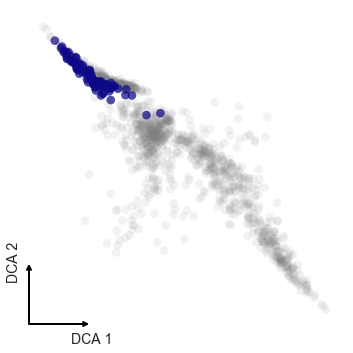

In [36]:
retina_DCA = DR(latent=retina_DCA.arcsinh_norm(norm=None, scale=1), name='DCA', barcodes=retina_DCA.barcodes)
retina_DCA.plot_barcodes(ranks=['4']) 

In [37]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_DCA.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_DCA.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, knn

R: 0.1835
EMD: 0.3051
Knn Pres.: 78.9724
CPU times: user 272 ms, sys: 17.8 ms, total: 290 ms
Wall time: 293 ms


CPU times: user 9.97 s, sys: 302 ms, total: 10.3 s
Wall time: 9.78 s


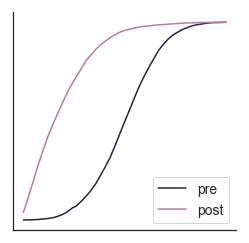

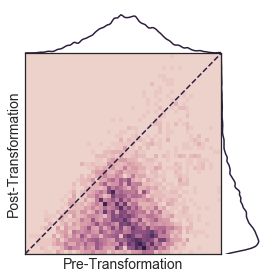

In [38]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

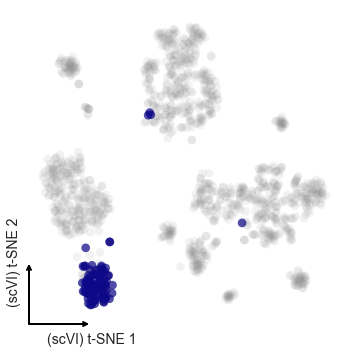

In [47]:
retina_scVI = DR.from_file('pymethods_out/retina_scVI.csv', name='scVI', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_scVI_tSNE = DR.from_file('pymethods_out/retina_scVI_tSNE.csv', name='(scVI) t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_scVI_tSNE.plot_barcodes(ranks=['4']) # rods & cones

In [48]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_scVI.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_scVI.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, knn

R: 0.4052
EMD: 0.1003
Knn Pres.: 61.8606
CPU times: user 292 ms, sys: 24.5 ms, total: 316 ms
Wall time: 287 ms


CPU times: user 10 s, sys: 276 ms, total: 10.3 s
Wall time: 9.87 s


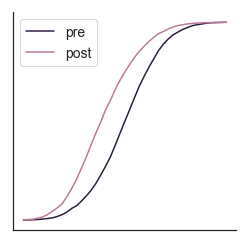

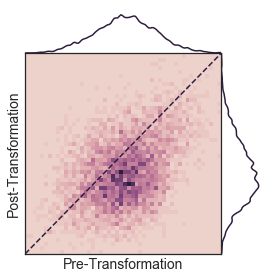

In [49]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

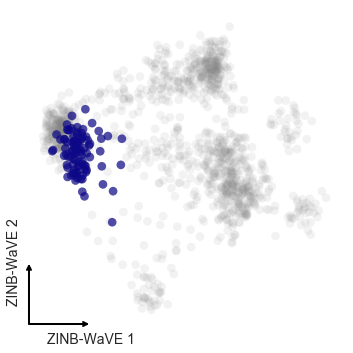

In [50]:
retina_ZINBWAVE = DR.from_file('Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_ZINBWAVE.plot_barcodes(ranks=['4']) # cones
retina_ZINBWAVE.plot_barcodes(ranks=['4'], figsize=(4,4), save_to='../images/cones_ZINBWAVE.png')

In [51]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_ZINBWAVE.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_ZINBWAVE.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, knn

R: 0.3037
EMD: 0.274
Knn Pres.: 60.5251
CPU times: user 379 ms, sys: 38.4 ms, total: 417 ms
Wall time: 420 ms


CPU times: user 10.1 s, sys: 325 ms, total: 10.4 s
Wall time: 10 s


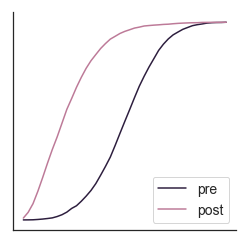

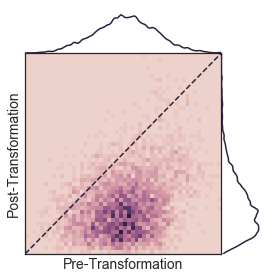

In [52]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

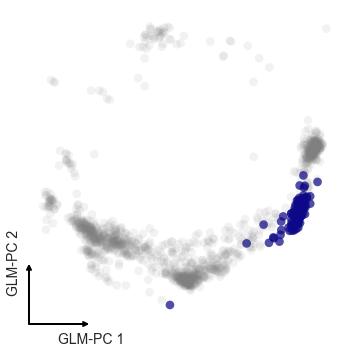

In [53]:
retina_GLMPCA = DR.from_file('Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_GLMPCA.plot_barcodes(ranks=['4']) # rods & cones

In [54]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD= distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_GLMPCA.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_GLMPCA.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, knn

R: 0.3384
EMD: 0.3941
Knn Pres.: 60.2082
CPU times: user 303 ms, sys: 19.1 ms, total: 323 ms
Wall time: 325 ms


CPU times: user 9.89 s, sys: 249 ms, total: 10.1 s
Wall time: 9.61 s


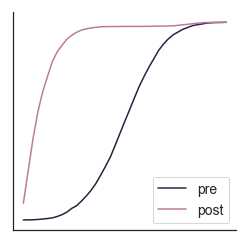

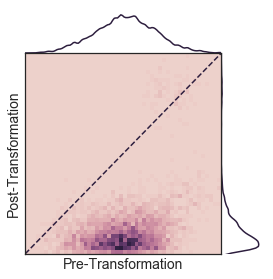

In [56]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

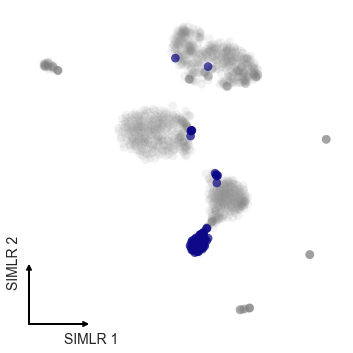

In [57]:
retina_SIMLR = DR.from_file('Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_SIMLR.plot_barcodes(ranks=['4']) # rods & cones

In [58]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=retina.distance_matrix(ranks=['4'],transform='arcsinh'), post=retina_SIMLR.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh', ranks=['4']), post=retina_SIMLR.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, knn

R: 0.2534
EMD: 0.3539
Knn Pres.: 74.1512
CPU times: user 276 ms, sys: 22.9 ms, total: 299 ms
Wall time: 303 ms


CPU times: user 9.85 s, sys: 253 ms, total: 10.1 s
Wall time: 9.61 s


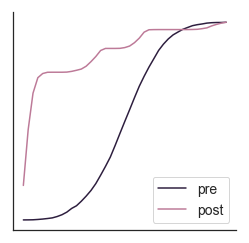

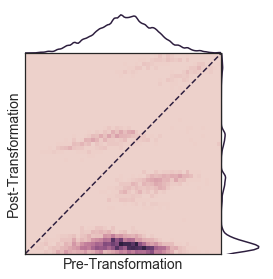

In [59]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/cones_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# Colon

In [60]:
colon.barcode_counts()

0.0    274
1.0    273
2.0    167
3.0    140
4.0    135
5.0    128
Name: Barcode, dtype: int64

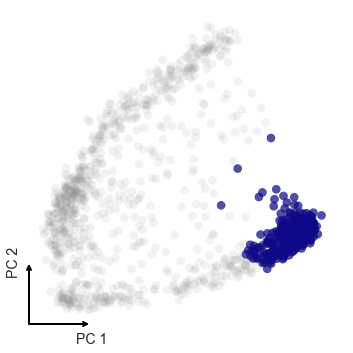

In [61]:
colon_PCA2 = fcc_PCA(matrix=colon.arcsinh_norm(), barcodes=colon.barcodes, n_components=2)
colon_PCA2.plot_barcodes(ranks=['1']) # mature colonocytes

In [62]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_PCA2.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_PCA2.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, knn

R: 0.4749
EMD: 0.1293
Knn Pres.: 84.3524
CPU times: user 892 ms, sys: 134 ms, total: 1.03 s
Wall time: 1.04 s


CPU times: user 10.2 s, sys: 343 ms, total: 10.5 s
Wall time: 10.1 s


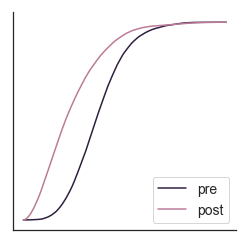

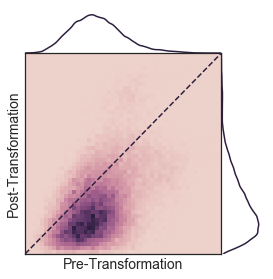

In [63]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [64]:
colon_PCA10 = fcc_PCA(matrix=colon.arcsinh_norm(), barcodes=colon.barcodes, n_components=10)

In [65]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_PCA10.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_PCA10.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (10)'], final_distance_stats['Colon']['EMD']['PCA (10)'], final_distance_stats['Colon']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, knn

R: 0.7763
EMD: 0.0369
Knn Pres.: 90.1085
CPU times: user 842 ms, sys: 50.5 ms, total: 893 ms
Wall time: 901 ms


CPU times: user 10 s, sys: 292 ms, total: 10.3 s
Wall time: 9.83 s


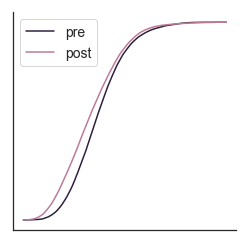

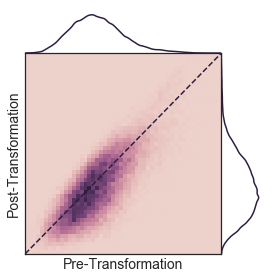

In [66]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_PCA10_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

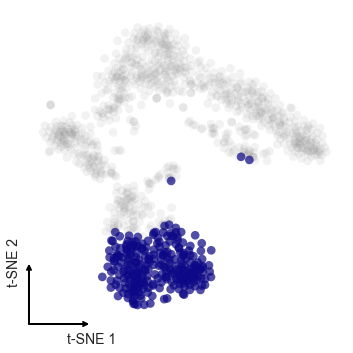

In [67]:
colon_tSNE = DR.from_file('pymethods_out/colon_tSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_tSNE.plot_barcodes(ranks=['1']) 

In [68]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['4'],transform='arcsinh'), post=colon_tSNE.distance_matrix(ranks=['4']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['4']), post=colon_tSNE.knn_graph(k, ranks=['4']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, knn

R: 0.5587
EMD: 0.1542
Knn Pres.: 79.4568
CPU times: user 342 ms, sys: 22 ms, total: 364 ms
Wall time: 368 ms


CPU times: user 9.99 s, sys: 284 ms, total: 10.3 s
Wall time: 9.78 s


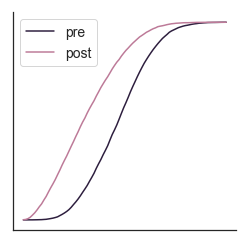

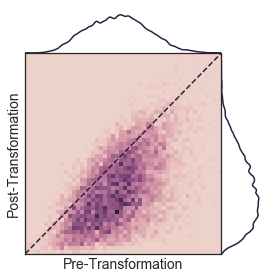

In [69]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

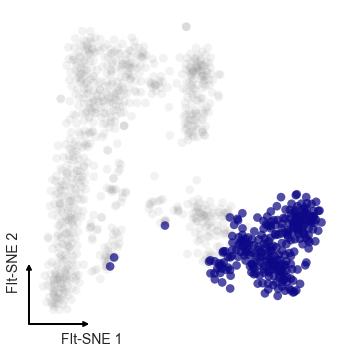

In [70]:
colon_FItSNE = DR.from_file('pymethods_out/colon_FItSNE.csv', name='FIt-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_FItSNE.plot_barcodes(ranks=['1']) # mature goblet cells

In [71]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_FItSNE.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_FItSNE.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['FIt-SNE'], final_distance_stats['Colon']['EMD']['FIt-SNE'], final_distance_stats['Colon']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, knn

R: 0.4673
EMD: 0.1726
Knn Pres.: 87.6585
CPU times: user 921 ms, sys: 150 ms, total: 1.07 s
Wall time: 1.09 s


CPU times: user 10 s, sys: 291 ms, total: 10.3 s
Wall time: 9.82 s


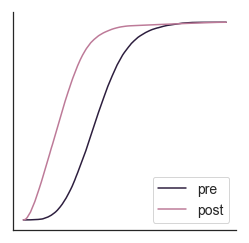

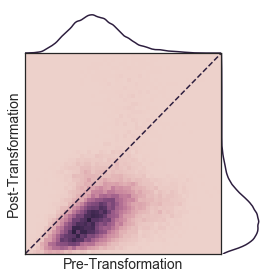

In [72]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

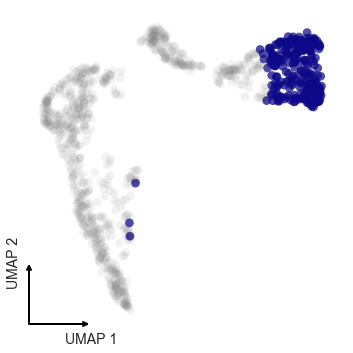

In [73]:
colon_UMAP = DR.from_file('pymethods_out/colon_UMAP.csv', name='UMAP', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_UMAP.plot_barcodes(ranks=['1']) 

In [74]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_UMAP.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_UMAP.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, knn

R: 0.3863
EMD: 0.2375
Knn Pres.: 87.4143
CPU times: user 821 ms, sys: 27.7 ms, total: 849 ms
Wall time: 860 ms


CPU times: user 9.97 s, sys: 310 ms, total: 10.3 s
Wall time: 9.75 s


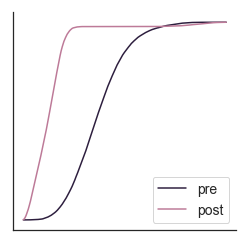

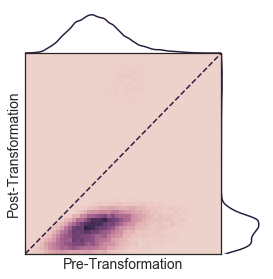

In [75]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

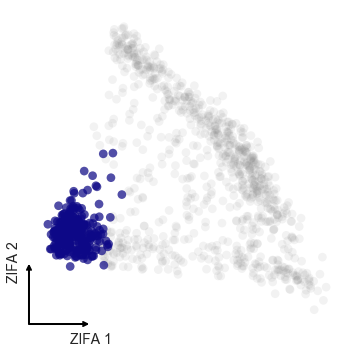

In [77]:
colon_ZIFA = DR.from_file('pymethods_out/colon_ZIFA.csv', name='ZIFA', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_ZIFA.plot_barcodes(ranks=['1']) # mature goblet cells

In [78]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_ZIFA.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_ZIFA.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, knn

R: 0.5806
EMD: 0.1544
Knn Pres.: 84.4195
CPU times: user 912 ms, sys: 142 ms, total: 1.05 s
Wall time: 1.06 s


CPU times: user 10.1 s, sys: 291 ms, total: 10.3 s
Wall time: 9.83 s


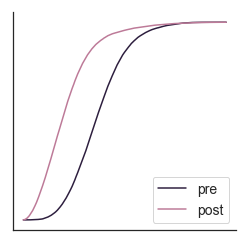

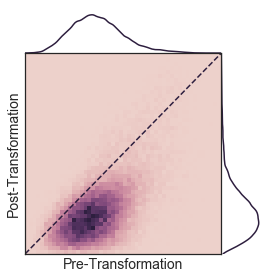

In [79]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

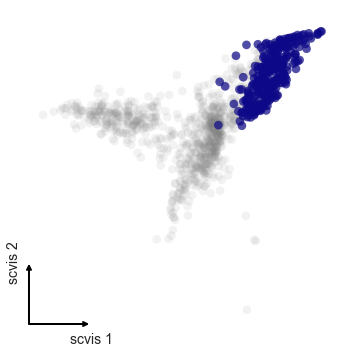

In [80]:
colon_scvis = DR.from_file('scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', name='scvis', labels=[0,0], barcodefile='pymethods_out/colon_clu.csv')
colon_scvis.plot_barcodes(ranks=['1']) # mature goblet cells

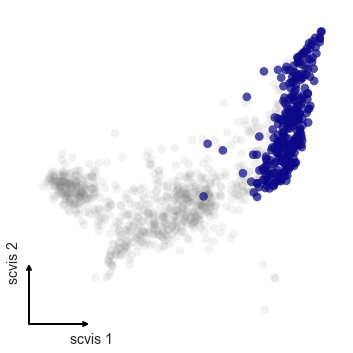

In [81]:
colon_scvis = DR(latent=colon_scvis.arcsinh_norm(norm=None, scale=1), name='scvis', barcodes=colon_scvis.barcodes)
colon_scvis.plot_barcodes(ranks=['1']) 

In [82]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_scvis.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_scvis.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, knn

R: 0.2707
EMD: 0.1653
Knn Pres.: 83.7271
CPU times: user 921 ms, sys: 157 ms, total: 1.08 s
Wall time: 1.09 s


CPU times: user 9.92 s, sys: 293 ms, total: 10.2 s
Wall time: 9.61 s


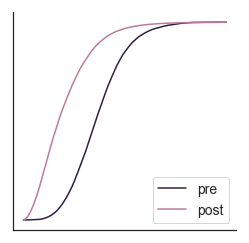

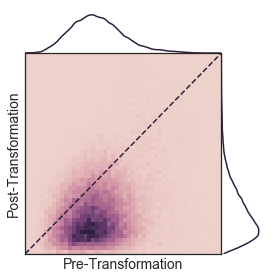

In [83]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

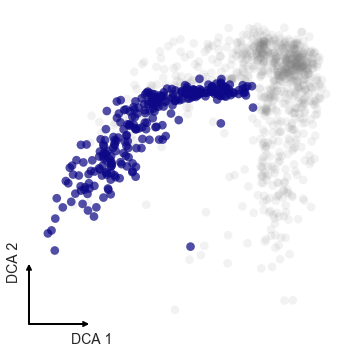

In [87]:
colon_DCA = DR.from_file('pymethods_out/colon_DCA.csv', name='DCA', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_DCA.plot_barcodes(ranks=['1']) # mature goblet cells

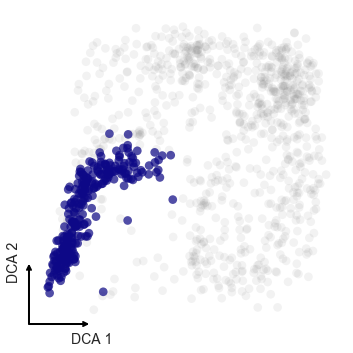

In [88]:
colon_DCA = DR(latent=colon_DCA.arcsinh_norm(norm=None, scale=1), name='DCA', barcodes=colon_DCA.barcodes)
colon_DCA.plot_barcodes(ranks=['1']) 
colon_DCA.plot_barcodes(ranks=['1'], figsize=(4,4), save_to='../images/colonocyte_DCA.png')

In [89]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_DCA.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_DCA.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, knn

R: 0.279
EMD: 0.0793
Knn Pres.: 83.2226
CPU times: user 885 ms, sys: 140 ms, total: 1.03 s
Wall time: 1.03 s


CPU times: user 10.1 s, sys: 324 ms, total: 10.4 s
Wall time: 9.94 s


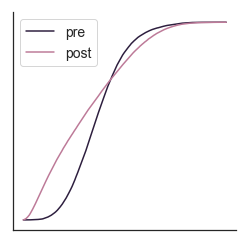

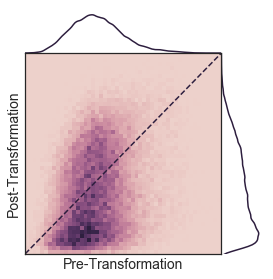

In [90]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

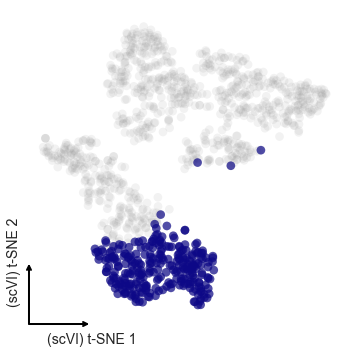

In [91]:
colon_scVI = DR.from_file('pymethods_out/colon_scVI.csv', name='scVI', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_scVI_tSNE = DR.from_file('pymethods_out/colon_scVI_tSNE.csv', name='(scVI) t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_scVI_tSNE.plot_barcodes(ranks=['1']) # rods & cones

In [92]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_scVI.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_scVI.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, knn

R: 0.7165
EMD: 0.0459
Knn Pres.: 88.6165
CPU times: user 832 ms, sys: 33.3 ms, total: 865 ms
Wall time: 872 ms


CPU times: user 10.1 s, sys: 410 ms, total: 10.5 s
Wall time: 10.2 s


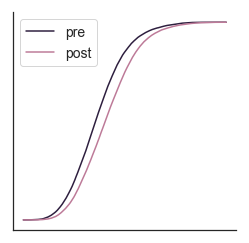

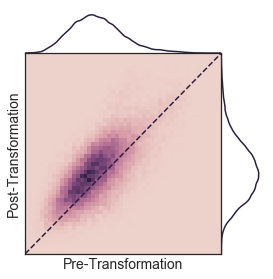

In [93]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

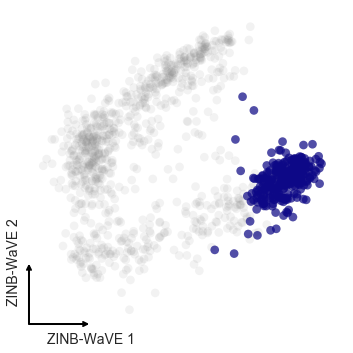

In [94]:
colon_ZINBWAVE = DR.from_file('Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_ZINBWAVE.plot_barcodes(ranks=['1']) 

In [95]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_ZINBWAVE.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_ZINBWAVE.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, knn

R: 0.4793
EMD: 0.1724
Knn Pres.: 83.1743
CPU times: user 859 ms, sys: 76.6 ms, total: 936 ms
Wall time: 944 ms


CPU times: user 9.96 s, sys: 348 ms, total: 10.3 s
Wall time: 9.8 s


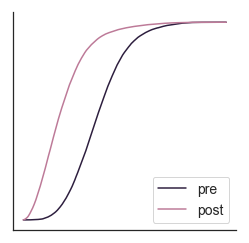

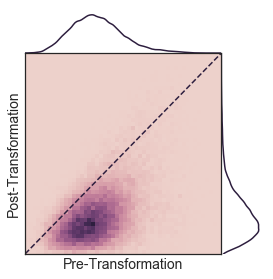

In [96]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

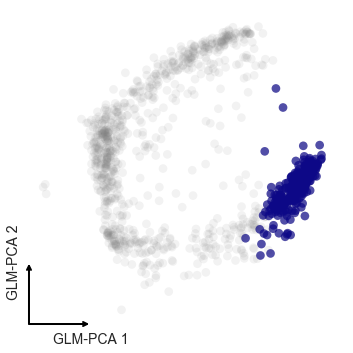

In [97]:
colon_GLMPCA = DR.from_file('Rmethods_out/colon_GLM-PCA.csv', name='GLM-PCA', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_GLMPCA.plot_barcodes(ranks=['1']) 

In [98]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_GLMPCA.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_GLMPCA.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, knn

R: 0.4209
EMD: 0.1682
Knn Pres.: 83.0589
CPU times: user 815 ms, sys: 44.4 ms, total: 860 ms
Wall time: 867 ms


CPU times: user 9.97 s, sys: 341 ms, total: 10.3 s
Wall time: 9.81 s


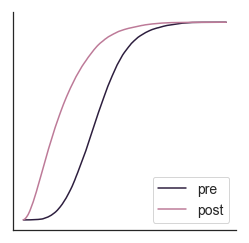

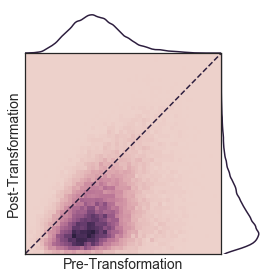

In [99]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

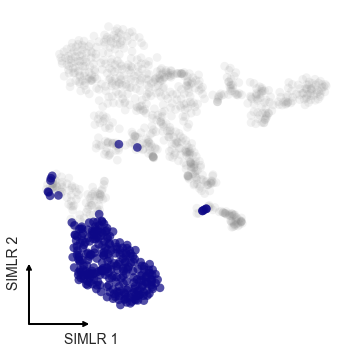

In [100]:
colon_SIMLR = DR.from_file('Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_SIMLR.plot_barcodes(ranks=['1']) # mature goblet cells

In [101]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=colon.distance_matrix(ranks=['1'],transform='arcsinh'), post=colon_SIMLR.distance_matrix(ranks=['1']))
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh', ranks=['1']), post=colon_SIMLR.knn_graph(k, ranks=['1']))
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, knn

R: 0.5918
EMD: 0.1049
Knn Pres.: 88.383
CPU times: user 957 ms, sys: 196 ms, total: 1.15 s
Wall time: 1.16 s


CPU times: user 10.1 s, sys: 331 ms, total: 10.4 s
Wall time: 9.98 s


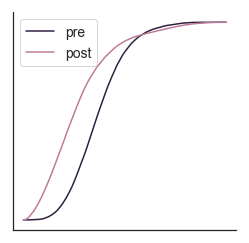

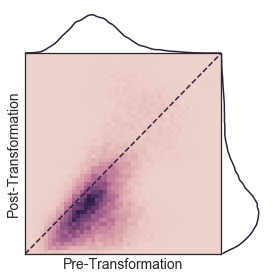

In [102]:
%%time
# output plots to file
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)

joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colonocyte_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### Summary Metrics

In [103]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])
retina_sum = retina_sum.sort_values(by='R')
retina_sum = retina_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
retina_sum.to_csv('retina_local_metrics.csv')

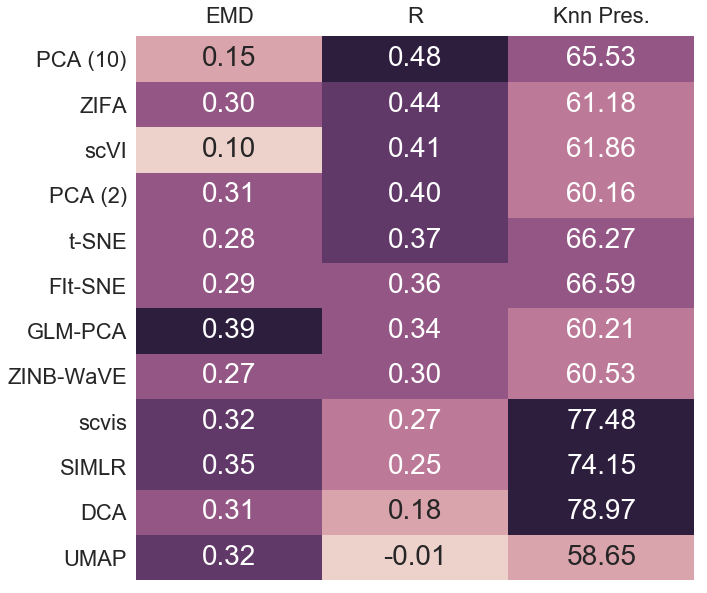

In [104]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.savefig(fname='../images/retina_local_metrics.png', transparent=True, bbox_inches='tight')

In [105]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])
colon_sum = colon_sum.sort_values(by='R')
colon_sum = colon_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
colon_sum.to_csv('colon_local_metrics.csv')

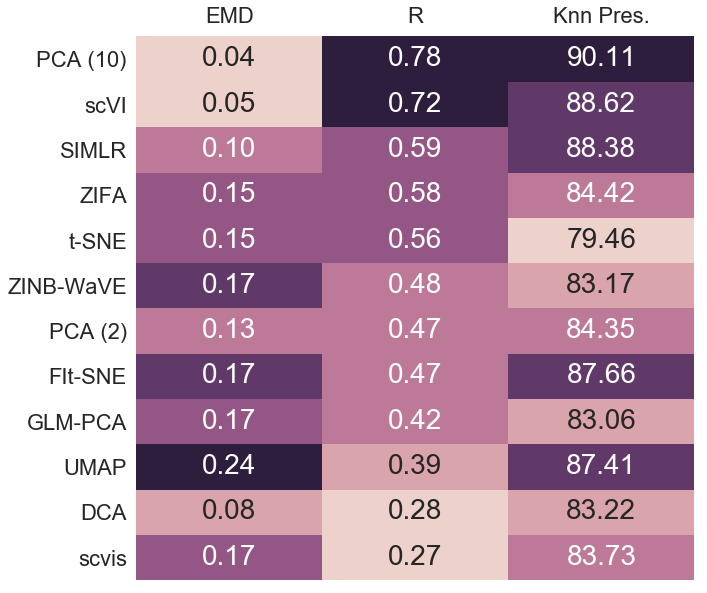

In [106]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.savefig(fname='../images/colon_local_metrics.png', transparent=True, bbox_inches='tight')